In [30]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
import urllib.request 
url = 'https://raw.githubusercontent.com/HIPS/neural-fingerprint/master/data/2015-05-24-delaney/ci034243xsi20040112_053635.txt'
urllib.request.urlretrieve(url, 'water_solubility.txt') 
df = pd.read_csv('water_solubility.txt', sep=',') 
PandasTools.AddMoleculeColumnToFrame(frame=df, smilesCol='smiles')
df.columns = ['ID', 'm_sol', 'p_sol', 'SMILES', 'ROMol']

In [240]:
mols = [Chem.MolFromSmiles(i) for i in df['SMILES']]

maccskeys = []
for m in mols:
    maccskey = [x for x in AllChem.GetMACCSKeysFingerprint(m)]
    maccskeys.append(maccskey)
X = np.array(maccskeys)
y = df['m_sol']

In [367]:
X.shape

(1144, 167)

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
regr = RandomForestRegressor(n_estimators=100,random_state=0)
regr.fit(X, y)
mean_absolute_error(regr.predict(X),y)

0.3694205637413728

In [33]:
import copy

In [34]:
def logp_calc(x):
    return regr.predict(x.reshape(1, -1))

In [35]:
from numpy.random import randint
from numpy.random import rand

In [36]:
y_pred = regr.predict(X)
y_pred.max()

1.1810999999999974

In [37]:
init_mk = np.ones(X.shape[1])
logp_calc(init_mk)

array([-4.1148125])

In [38]:
np.random.seed(233)
def mutation(pop,r_mut):
    for i in range(len(pop)):
        if rand() < r_mut:
            pop[i] = randint(0,2)
    return pop

In [71]:
def simulated_annealing(calculator,n_iters,temp):
    init = np.ones(X.shape[1])
    best = init
    best_logp = logp_calc(best)
    curr, curr_eval = best, best_logp 
    route = []
    for i in range(n_iters):
        molecule_new = mutation(curr,0.8)
        molecule_new_c = molecule_new.copy()
        logp_new = calculator(molecule_new)
        route.append([molecule_new_c,logp_new])
        if logp_new > best_logp:
            best, best_logp = molecule_new, logp_new
            print('n_iter:',i, 'best_logp: ', best_logp)
        diff = logp_new - curr_eval
        t = temp / float(i + 1)
        metropolis = np.exp(diff / t)
        if diff > 0 or rand() < metropolis:
            curr, curr_eval = molecule_new, logp_new 
            curr_c = curr.copy()
    return [best, best_logp],route

In [70]:
route

[[array([0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
         1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
         1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0.,
         1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
         0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.]),
  array([-3.31267747])],
 [array([1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
         0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 

In [72]:
res,route = simulated_annealing(logp_calc, n_iters = 1000, temp=10)

n_iter: 0 best_logp:  [-4.00765117]
n_iter: 1 best_logp:  [-3.94323083]
n_iter: 2 best_logp:  [-3.04331611]
n_iter: 7 best_logp:  [-2.41317]
n_iter: 58 best_logp:  [-2.00373766]
n_iter: 129 best_logp:  [-1.74292833]
n_iter: 207 best_logp:  [-1.70200885]
n_iter: 235 best_logp:  [-1.53426]
n_iter: 265 best_logp:  [-0.86409167]
n_iter: 711 best_logp:  [-0.446845]
n_iter: 725 best_logp:  [-0.36119333]


In [94]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state = 0, init= 'pca')

In [241]:
gen_fin = np.array([route[i][0] for i in range(1000)])

In [242]:
gen_logp = [route[i][1][0] for i in range(1000)]

In [243]:
x_all = np.concatenate([gen_fin,X])
y_all = np.array(gen_logp+y.tolist())

In [181]:
Z = tsne.fit_transform(x_all)

D:\anaconda\envs\pytorchenv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
D:\anaconda\envs\pytorchenv\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<IPython.core.display.Javascript object>


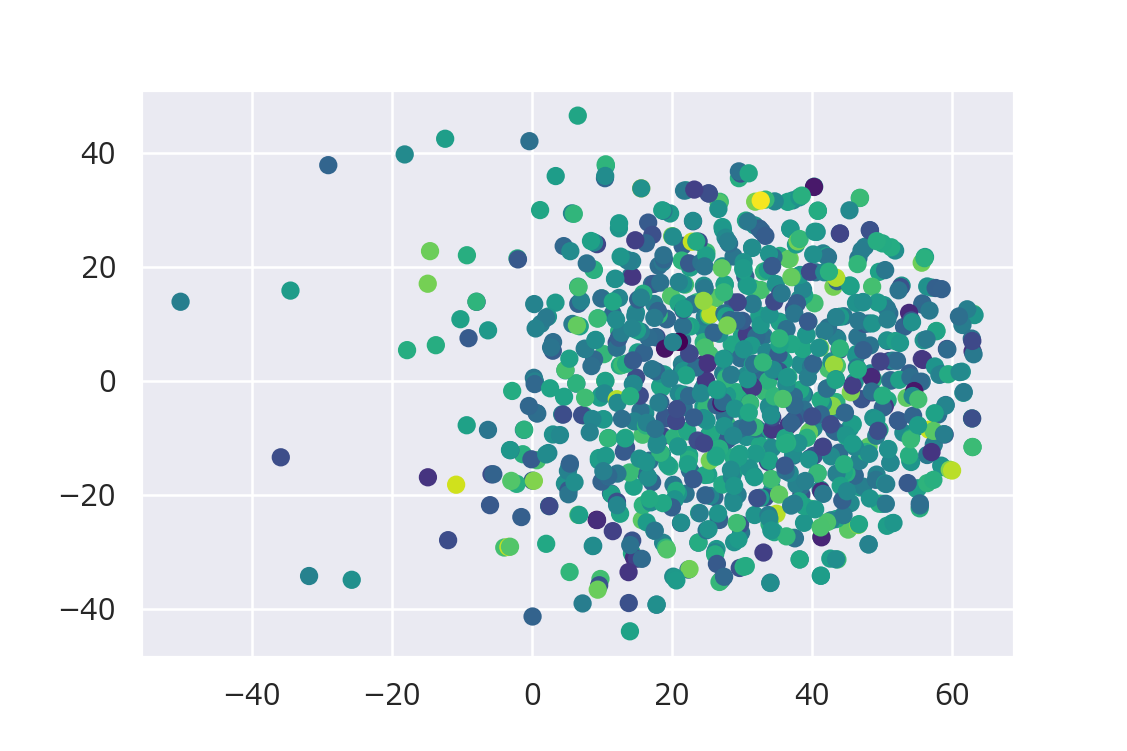

In [380]:
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()

ims = []
for i in range(1000):
    im = plt.scatter(Z[:,0][:i],Z[:,1][:i],c=gen_logp[:i],cmap='viridis')
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=2)

plt.show()

<IPython.core.display.Javascript object>


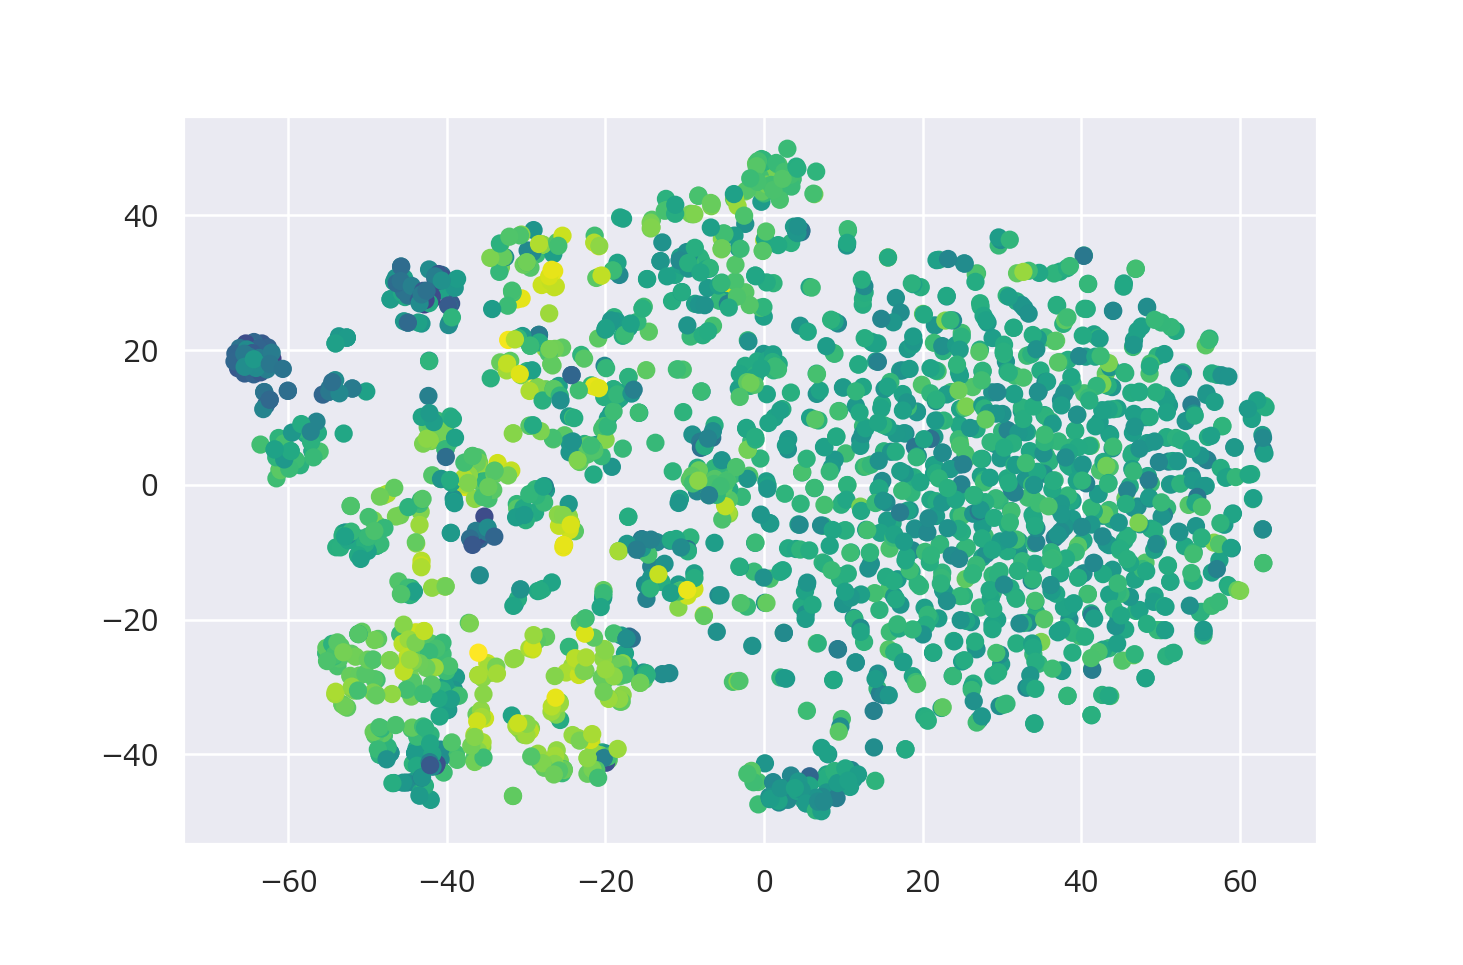

In [381]:
fig = plt.figure()
plt.scatter(Z[:,0],Z[:,1],c=y_all,cmap='viridis')

# plt.scatter(Z[:,0][:1],Z[:,1][:1],c=y_all[:1],cmap='viridis')
# plt.scatter(Z[:,0][1000:],Z[:,1][1000:],c=y_all[1000:],cmap='viridis',alpha=0.2)
plt.show()

In [333]:
Z[:,0].shape

(2144,)